# *A new measure of public transit accessibility* 

## 0 - Preprocessing

### 0.1 - install and load packages

In [ ]:
!pip install googlemaps
!pip install geopandas
!pip install matplotlib_scalebar

In [3]:
import pandas as pd, seaborn as sns
import json, requests, geopandas, googlemaps, time, pytz, os
from google.colab import drive
from datetime import datetime
from shapely.geometry.point import Point
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

### 0.2 - mount drive and inspect wdir

In [4]:
drive.mount("/content/drive/")
os.chdir('/content/drive/MyDrive/#######')

Mounted at /content/drive/


In [ ]:
print('------------./api/------------')
!ls ./api/
print('\n---------./shapefiles/--------')
!ls ./shapefiles/
print('\n-----------./ipeds/-----------')
!ls ./ipeds/

### 0.3 - load directions api keys and initialize client

In [ ]:
key_df = pd.read_csv('./api/keys.csv')
keys = list(key_df.key)

In [ ]:
client1 = googlemaps.Client(key=keys[0], queries_per_second=50)
client2 = googlemaps.Client(key=keys[1], queries_per_second=50)
#etc.

### 0.4 - Load blockgroup shapefile and plot
- shape of the data is 2156 x 5

In [6]:
#Save the block group centroids in separate lat/lng columns
bklyn_blockgroups = geopandas.read_file("./shapefiles/brooklyn_blockgroups_WGS84.shp").to_crs(4326)
bklyn_blockgroups["centroid_x"] = bklyn_blockgroups['geometry'].to_crs(4326).centroid.x
bklyn_blockgroups["centroid_y"] = bklyn_blockgroups['geometry'].to_crs(4326).centroid.y

<ipython-input-6-8f182cc6e416>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bklyn_blockgroups["centroid_x"] = bklyn_blockgroups['geometry'].to_crs(4326).centroid.x
<ipython-input-6-8f182cc6e416>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bklyn_blockgroups["centroid_y"] = bklyn_blockgroups['geometry'].to_crs(4326).centroid.y


<ipython-input-7-44d074b9bc4c>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bklyn_blockgroups.centroid.plot(ax=ax,


Text(0.5, 1.0, 'Brooklyn Census Tracts with Centroids - 2066 total origins')

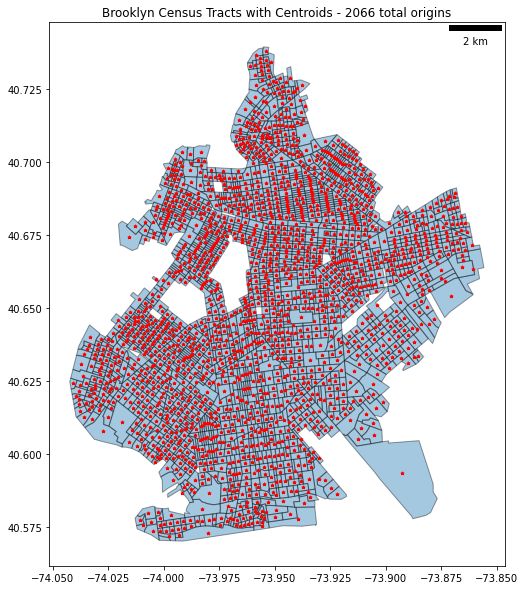

In [7]:
#scalebar conversion (degrees to meters using arbitrary points)
points = geopandas.GeoSeries([Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

fig, ax = plt.subplots(figsize=(20,10))
bklyn_blockgroups.plot(ax=ax,legend = True, alpha=0.4, edgecolor='black')
bklyn_blockgroups.centroid.plot(ax=ax,
                            marker='*', color='red', markersize=10)
ax.add_artist(ScaleBar(distance_meters)) 
plt.title(f'Brooklyn Census Tracts with Centroids - {len(bklyn_blockgroups)} total origins')

### 0.5 - Load destinations (schools) and inspect
- 126 schools x 62 variables
- in NY and NJ (anything accessible from Brooklyn)
- includes access via LIRR

In [8]:
#Load schools data - 
schools = pd.read_csv("./ipeds/hd2021_target_set.csv")

schools.head(5)

,UNITID,STABBR,INSTNM,LONGITUD,LATITUDE,ADDR,CITY,ZIP,own_ICLEVEL,own_INSTSIZE,...,own_ADMCON7,APPLCN,APPLCNM,APPLCNW,ADMSSN,ADMSSNM,ADMSSNW,LON_CTR,LAT_CTR,crow_flies
0,183488,NJ,Eastwick College-Hackensack,-74.040491,40.885847,250 Moore Street,Hackensack,07601,2-but-less-than 4-year,"Under 1,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.9442,40.6782,15.192355
1,183743,NJ,Bergen Community College,-74.088804,40.951782,400 Paramus Rd,Paramus,07652-1595,2-but-less-than 4-year,"10,000 - 19,999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.9442,40.6782,20.343355
2,183789,NJ,Berkeley College-Woodland Park,-74.189483,40.898587,44 Rifle Camp Rd,Woodland Park,07424,4-year or higher,"1,000 - 4,999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.9442,40.6782,19.918572
3,183822,NJ,Bloomfield College,-74.194309,40.795105,467 Franklin St,Bloomfield,07003,4-year or higher,"1,000 - 4,999",...,Test Scores - Considered but not required,2737.0,1038.0,1699.0,2300.0,841.0,1459.0,-73.9442,40.6782,15.407804
4,183910,NJ,Caldwell University,-74.272571,40.832753,120 Bloomfield Avenue,Caldwell,07006-6195,4-year or higher,"1,000 - 4,999",...,Test Scores - Considered but not required,3494.0,1352.0,2142.0,3353.0,1287.0,2066.0,-73.9442,40.6782,20.263608


In [9]:
## NY/NJ split
## 101 schools in NY, 25 in NJ
print(schools.STABBR.value_counts())

NY    101
NJ     25
Name: STABBR, dtype: int64


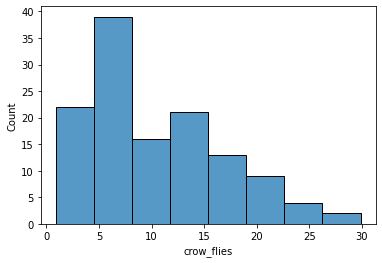

In [10]:
## School distance as the crow files from center of brooklyn (in miles)
## Skewed right, as we would expect
## No school more than 30 miles from center of brooklyn.
sns.histplot(schools.crow_flies)

### 0.6 - reshape inputs (blockgroup centroids)
- 2066 blockgroups

In [11]:
input_blockgroups = bklyn_blockgroups[['GEOID', 'centroid_y', 'centroid_x']]
input_blockgroups.head(5)

,GEOID,centroid_y,centroid_x
0,360470034001,40.640144,-74.033473
1,360470374015,40.585491,-73.967844
2,360470149022,40.660818,-73.986351
3,360470762003,40.626915,-73.956705
4,360470345001,40.672076,-73.933621


### 0.7 - reshape inputs (school point coordinates)
- 126 schools



In [12]:
input_schools = schools[['UNITID', 'LATITUDE', 'LONGITUD']]
input_schools.head()

,UNITID,LATITUDE,LONGITUD
0,183488,40.885847,-74.040491
1,183743,40.951782,-74.088804
2,183789,40.898587,-74.189483
3,183822,40.795105,-74.194309
4,183910,40.832753,-74.272571


## 1 - Create helper functions to process requests

### 1.1 - Helper function to handle a single request

In [ ]:
def single_request_directions(input_origin, input_destination, client, **kwargs):

  #Execute the get request for the given batch
  r = client.directions(origin=(input_origin[1], input_origin[2]), 
                       destination=(input_destination[1], input_destination[2]), 
                          mode="transit", **kwargs)
  
  try:
    steps = r[0]['legs'][0]['steps']
    df = pd.DataFrame(steps).drop(columns=['polyline'])
    df['origin'] = input_origin[0]
    df['destination'] = input_destination[0]
    df['actual_departure'] = r[0]['legs'][0]['departure_time']['text']
    df['actual_arrival'] = r[0]['legs'][0]['arrival_time']['text']
    df['total_time'] = (r[0]['legs'][0]['arrival_time']['value']-r[0]['legs'][0]['departure_time']['value'])/60

  except Exception as e:
    df = pd.DataFrame([{'distance': -999, 'duration': -999, 'end_location':-999, 
                        "html_instructions":-999, "start_location":-999, "steps":-999, 
                        "travel_mode":-999, "transit_details":-999,
                        "actual_departure":-999, "actual_arrival":-999, 
                        "total_time":-999}]) #append something more useful instead of nothing
    df['origin'] = input_origin[0]
    df['destination'] = input_destination[0]

  return df

### 1.1 - Helper function to handle a batch of requests

In [ ]:
def process_directions(input_origins, input_destinations, client, **kwargs):

  #convert ods to lists
  origins = list(input_origins.to_records(index=False))
  destinations = list(input_destinations.to_records(index=False))

  #initialize storage df
  store = pd.DataFrame()
  request_count = 0

  #execute loop
  for destination in enumerate(destinations):
    for origin in enumerate(origins):
      result = single_request_directions(origin[1], destination[1], client, **kwargs)

      #append other information
      result['request_time'] = datetime.strftime(datetime.now().astimezone(pytz.timezone('America/New_York')),
                                           "%m/%d/%Y %H:%M:%S %Z")
      #adjust counters and sleep
      request_count += 1
      time.sleep(0.005)
      
      #store the result and print a message
      store = store.append(result)
      print(f'Queried pair: {origin[1][0]}-{destination[1][0]} ... origin {origin[0]+1}/{len(origins)}, destination {destination[0]+1}/{len(destinations)} ... request {request_count} of {len(origins)*len(destinations)}')
  
  #append final information 
  try:
    store['depart_time'] = datetime.strftime(kwargs['departure_time'], "%m/%d/%Y %H:%M:%S %Z")
  except Exception:
    store['depart_time'] = "NA"
  
  try:
    store['arrival_time'] = datetime.strftime(kwargs['arrival_time'], "%m/%d/%Y %H:%M:%S %Z")
  except Exception:
    store['arrival_time'] = "NA"

  try:
    store['transit_routing_preference'] = kwargs['transit_routing_preference']
  except Exception:
    store['transit_routing_preference'] = "standard"

  #print a final message
  print(f'{request_count} total requests made for {len(origins)} origins and {len(destinations)} destinations.')

  return store 

## 2 - Compile and send the requests ⚠⚠⚠ 
- costs money, be careful!

### 2.1 - Morning batches
- **Set desired arrival time at destination** Note 5 hours ahead due to time zone
- Watch out for daylight time, this could change the number above (it will be 4 or 5 hours ahead)
- process time is about 4 minutes hour per 1k requests (15k requests per hour)
- 260316 requests in total (2066 x 126) per time period (morning/evening)

In [16]:
desired_arrival = datetime.strptime('Jan 05 2023 2:00PM', '%b %d %Y %I:%M%p').astimezone(pytz.timezone('America/New_York'))
print(f'desired_arrival is {datetime.strftime(desired_arrival, "%m/%d/%Y %H:%M:%S %Z")}')

desired_arrival is 01/05/2023 09:00:00 EST


In [ ]:
def run_batch(client, client_name, schools_start_index, schools_end_index, blockgroup_start_index = 0, blockgroup_end_index = 2114):

  # Chunk schools into batches
  origins = input_blockgroups.iloc[blockgroup_start_index:blockgroup_end_index]
  destinations = input_schools.iloc[schools_start_index:schools_end_index]

  # Crunch time! Send the requests
  raw_morning = process_directions(origins, destinations, client = client, arrival_time = desired_arrival)

  # Save out, in csv and pkl, just in case
  raw_morning.to_csv(f'./data-store/morning_{client_name}_{schools_start_index}-{schools_end_index}.csv')
  raw_morning.to_pickle(f'./data-store/morning_{client_name}_{schools_start_index}-{schools_end_index}.pkl')


### 2.2 - Evening batches

- **Set desired departure time** Note 5 hours ahead due to time zone
- Watch out for daylight time, this could change the number above (it will be 4 or 5 hours ahead)
- process time is about 4 minutes hour per 1k requests (15k requests per hour)
- 260316 requests in total (2066 x 126) per time period (morning/evening)

In [15]:
desired_departure = datetime.strptime('Jan 06 2022  10:00PM', '%b %d %Y %I:%M%p').astimezone(pytz.timezone('America/New_York'))
print(f'desired_departure is {datetime.strftime(desired_departure, "%m/%d/%Y %H:%M:%S %Z")}')

desired_departure is 01/06/2022 17:00:00 EST


In [ ]:
def run_batch(client, client_name, schools_start_index, schools_end_index, blockgroup_start_index = 0, blockgroup_end_index = 2114):

  # Chunk schools into batches
  origins = input_schools.iloc[schools_start_index:schools_end_index]
  destinations = input_blockgroups.iloc[blockgroup_start_index:blockgroup_end_index]

  # Crunch time! Send the requests
  raw_evening = process_directions(origins, destinations, client = client, arrival_time = desired_arrival)

  # Save out, in csv and pkl, just in case
  raw_evening.to_csv(f'./data-store/evening_{client_name}_{schools_start_index}-{schools_end_index}.csv')
  raw_evening.to_pickle(f'./data-store/evening_{client_name}_{schools_start_index}-{schools_end_index}.pkl')
